In [9]:
import sys
sys.path.append('..')
sys.path.append('../..')
from data_utils import *
from waveforms.make_waveform import BatchedLightSimulation

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec
import yaml

import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

### Load in Data

In [29]:
# Loading in data
load_wfs = np.load('/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delayed_delta_t/delta_t_100phot.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

# Splitting data
val_ratio = 0.1
test_ratio = 0.0
total_size = len(dataset)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)
train_size = total_size - val_size - test_size
print(f"split sizes: {train_size, val_size, test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)

    # Normalizing waveforms
    waveforms = (waveforms - waveforms.mean(dim=1, keepdim=True)) / (waveforms.std(dim=1, keepdim=True) + 1e-8)
    waveforms = waveforms.unsqueeze(1)  # add channel dimension [B,1,L]

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list
    

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

split sizes: (90000, 10000, 0)


### Load in Both Models

In [30]:
from model import *
from utils import *
from transformer import *
from conformer import *

device='cuda'

MODEL_CLASSES = {
    "TransformerModel": TransformerModel,
    "ConformerModel": ConformerModel,
    "ConformerModelv2": ConformerModelv2,
    "UNet1D": UNet1D
}

def load_models(config_path, device="cuda"):
    with open(config_path, "r") as f:
        configs = yaml.safe_load(f)

    models = {}
    for name, cfg in configs.items():
        if not cfg.get("include", True):
            continue
            
        print(name)
        cls = MODEL_CLASSES[cfg["class"]]
        model = cls(**cfg.get("args", {}))
        model.to(device)

        checkpoint = torch.load(cfg["checkpoint"], map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()

        models[name] = model
    return models
    
models = load_models("model_list.yaml")
print(models.keys())  
# conformer = ConformerModel(d_model=256, num_heads=8, num_layers=4)
# checkpoint = torch.load("/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/conformer_5M_19.pth", weights_only=True)
# conformer.load_state_dict(checkpoint['model_state_dict'])
# conformer = conformer.to('cuda')  # move model to GPU if needed
# conformer.eval()

transformer_215
conformer_v5_drop


/lscratch/carsmith/tmp/ipykernel_223058/3892881517.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cfg["checkpoint"], map_location=device)


dict_keys(['transformer_215', 'conformer_v5_drop'])


In [31]:
# transformer = TransformerModel()
# checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/transformer_params_50epochs.pth", weights_only=True)
# transformer.load_state_dict(checkpoint['model_state_dict'])
# transformer = transformer.to('cuda')  # move model to GPU if needed
# transformer.eval()

### Plotting

In [36]:
waveform_batch_id = np.random.randint(0, 25, 1)[0]

device = 'cuda'
val_iter = iter(val_loader)
print(len(val_loader))

for i in range(1):  # first two batches
    waveforms, arrival_times, hit_times, photon_target, photon_list = next(val_iter)
    print(f"Batch {i} has waveforms shape {waveforms.shape}")
    
waveforms = waveforms.to(device)
wf = waveforms[waveform_batch_id]

# Store outputs and losses for each model
epoch = 6
all_outputs = {}
all_losses = {}
all_pred_hits = {}

for name, model in models.items():
    # Forward pass
    class_output, reg_output = model(waveforms)
    class_output = class_output.squeeze(1)

    # Compute loss and intermediate tensors
    loss, sampled_indices, masked_target, masked_output, output, target, masked_reg_output, masked_photon_target = \
        mined_bce_loss(
            waveforms, hit_times, photon_list,
            class_output, reg_output,
            epoch, device
        )

    # Predicted hits
    mask = torch.sigmoid(class_output[waveform_batch_id, :]) > 0.5
    pred_hits = torch.nonzero(mask, as_tuple=False).squeeze(1)

    # Store everything
    all_outputs[name] = {
        "class_output": class_output,
        "reg_output": reg_output,
        "sampled_indices": sampled_indices,
        "masked_target": masked_target,
        "masked_output": masked_output,
        "output": output,
        "target": target,
        "masked_reg_output": masked_reg_output,
        "masked_photon_target": masked_photon_target,
    }
    all_losses[name] = loss
    all_pred_hits[name] = pred_hits
# unet_class_output, unet_reg_output = conformer(waveforms)
# trans_class_output, trans_reg_output = transformer(waveforms)
# ticks = np.arange(wf.shape[1])

# epoch = 6
# loss, sampled_indices, masked_target, masked_output, output, target, masked_reg_output, masked_photon_target = mined_bce_loss(waveforms, hit_times, photon_list, unet_class_output, unet_reg_output, epoch, device)
# t_loss, t_sampled_indices, t_masked_target, t_masked_output, t_output, t_target, t_masked_reg_output, t_masked_photon_target = mined_bce_loss(waveforms, hit_times, photon_list, trans_class_output, trans_reg_output, epoch, device)

400
Batch 0 has waveforms shape torch.Size([25, 1, 8000])


In [37]:
# Predicted hits
# unet_class_output = unet_class_output.squeeze(1)
# trans_class_output = trans_class_output.squeeze(1)
# unet_mask = torch.sigmoid(unet_class_output[waveform_batch_id, :]) > 0.5
# trans_mask = torch.sigmoid(trans_class_output[waveform_batch_id, :]) > 0.5
# unet_pred_hits = torch.nonzero(unet_mask, as_tuple=False).squeeze(1)
# trans_pred_hits = torch.nonzero(trans_mask, as_tuple=False).squeeze(1)

In [38]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plot_residuals_all_models(wf, ticks, hit_times, waveform_batch_id, pred_hits_dict):
    """
    Plot waveform + residuals for all models in pred_hits_dict.
    2 models per row, each with 2 stacked panels.
    """
    n_models = len(pred_hits_dict)
    n_cols = 2
    n_rows = int(np.ceil(n_models / n_cols))

    fig = plt.figure(figsize=(14, 4 * n_rows))
    gs = gridspec.GridSpec(
        2 * n_rows, n_cols, 
        width_ratios=[1] * n_cols,
        height_ratios=[5, 2] * n_rows,
        hspace=0.04, wspace=0.3
    )

    # Helper plotting function
    def plot_one(ax_top, ax_bottom, pred_hits, title):
        ax_top.set_title(title, fontsize=14)
        ax_top.plot(ticks, wf.squeeze(0).cpu(), alpha=1, label='Waveform')

        # True hits
        true_ints = [int(t) for t in hit_times[waveform_batch_id]]
        for j, t in enumerate(true_ints):
            if t >= 0:
                ax_top.axvline(
                    x=t, color='r', linestyle='--', linewidth=2,
                    label='True arrival' if j == 0 else None
                )

        # Predicted hits
        for j, t in enumerate(pred_hits):
            ax_top.axvline(
                x=t.item(), color='g', linestyle='--', linewidth=2,
                label='Pred arrival' if j == 0 else None
            )

        # Residuals
        pred_ints = [int(t.item()) for t in pred_hits]
        deltas = []
        for p in pred_ints:
            closest_true = min(true_ints, key=lambda t: abs(t - p))
            deltas.append((p, p - closest_true))

        pred_ticks, delta_vals = zip(*deltas) if deltas else ([], [])
        ax_bottom.axhline(0, color='r', linestyle='-', linewidth=1, label='True Time')
        ax_bottom.scatter(pred_ticks, delta_vals, color='g', marker='o')
        ax_bottom.set_ylabel("Δ (Pred - Closest Hit)", fontsize=11)
        if delta_vals:
            range_lim = max(abs(np.min(delta_vals)), abs(np.max(delta_vals)))
        else:
            range_lim = 1
        ax_bottom.set_ylim(-range_lim - 0.25, range_lim + 0.25)
        ax_bottom.grid()
        ax_bottom.set_xlabel("Tick Index (1 ns resolution)", fontsize=11)

        # Legends and labels
        ax_top.legend()
        ax_top.set_ylabel("ADC", fontsize=11)
        ax_bottom.legend()

        # Formatting
        ax_top.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        for ax in [ax_top, ax_bottom]:
            ax.tick_params(axis='both', which='major', labelsize=10)

    # Iterate over models
    for idx, (name, pred_hits) in enumerate(pred_hits_dict.items()):
        row = idx // n_cols
        col = idx % n_cols

        ax_top = fig.add_subplot(gs[2*row, col])
        ax_bottom = fig.add_subplot(gs[2*row + 1, col], sharex=ax_top)

        plot_one(ax_top, ax_bottom, pred_hits, f"{name}: Waveform + Residuals")
    
    plt.show()

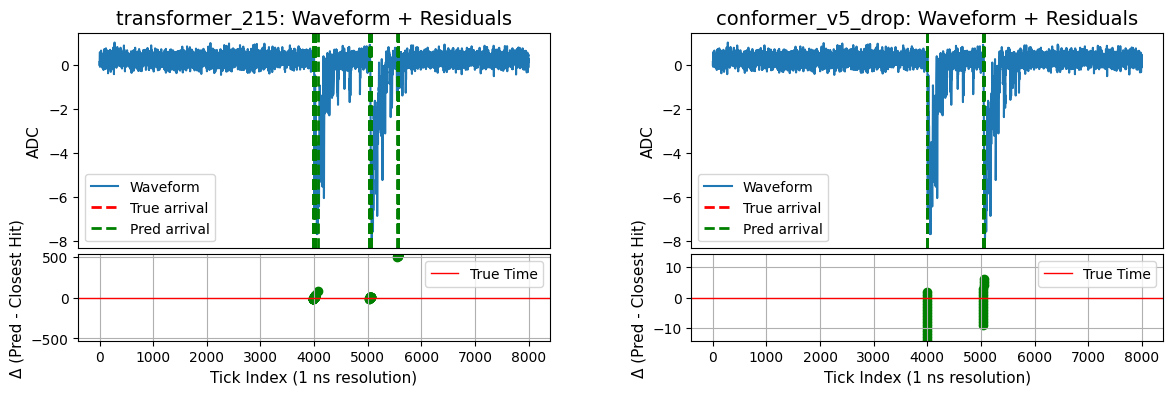

In [39]:
ticks = np.arange(wf.shape[1])
plot_residuals_all_models(
    wf, ticks, hit_times, waveform_batch_id,
    all_pred_hits  # dict: {"unet": unet_pred_hits, "transformer": trans_pred_hits, ...}
)

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plot_residuals_side_by_side(wf, ticks, hit_times, waveform_batch_id,
                                unet_pred_hits, trans_pred_hits):
    fig = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[5, 2], hspace=0.025, wspace=0.25)

    # ---- UNet panels (left column) ----
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)

    # ---- Transformer panels (right column) ----
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1], sharex=ax2)

    # ========== Helper plotting function ==========
    def plot_one(ax_top, ax_bottom, pred_hits, title):
        ax_top.set_title(title, fontsize=14)

        # Top panel: waveform + hits
        ax_top.plot(ticks, wf.squeeze(0).cpu(), alpha=1, label='Waveform')

        true_ints = [int(t) for t in hit_times[waveform_batch_id]]
        for j, t in enumerate(true_ints):
            if t >= 0:
                ax_top.axvline(
                    x=t, color='r', linestyle='--', linewidth=2,
                    label='True arrival' if j == 0 else None
                )

        for j, t in enumerate(pred_hits):
            ax_top.axvline(
                x=t.item(), color='g', linestyle='--', linewidth=2,
                label='Pred arrival' if j == 0 else None
            )

        pred_ints = [int(t.item()) for t in pred_hits]
        deltas = []
        for p in pred_ints:
            # find closest true hit
            closest_true = min(true_ints, key=lambda t: abs(t - p))
            delta_val = p - closest_true
            deltas.append((p, delta_val))

        # Bottom panel: residuals
        pred_ticks, delta_vals = zip(*deltas) if deltas else ([], [])
        ax_bottom.axhline(0, color='r', linestyle='-', linewidth=1, label='True Time')
        ax_bottom.scatter(pred_ticks, delta_vals, color='g', marker='o')
        ax_bottom.set_ylabel("Δ (Pred - Closest Hit)", fontsize=11)
        range_lim = max(abs(np.min(delta_vals)), abs(np.max(delta_vals))) if delta_vals else 1
        ax_bottom.set_ylim(-range_lim - 0.25, range_lim + 0.25)
        ax_bottom.grid()
        ax_bottom.set_xlabel("Tick Index (1 ns resolution)", fontsize=11)
        ax_bottom.legend()

        # Labels and ticks
        ax_top.legend()
        ax_top.set_ylabel("ADC", fontsize=11)

        # Remove x ticks on top
        ax_top.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax_bottom.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        # Make tick labels readable
        for ax in [ax_top, ax_bottom]:
            ax.tick_params(axis='both', which='major', labelsize=10)

    # ---- Apply to UNet ----
    plot_one(ax0, ax1, unet_pred_hits, "Conformer 5M: Waveform + Residuals")
    
    # ---- Apply to Transformer ----
    plot_one(ax2, ax3, trans_pred_hits, "Transformer 2M: Waveform + Residuals")
    
    plt.show()
    
plot_residuals_side_by_side(
    wf, ticks, hit_times, waveform_batch_id,
    unet_pred_hits, trans_pred_hits
)

NameError: name 'unet_pred_hits' is not defined

### Evaluating Accuracy & Purity

In [15]:
from hybrid_loss import *
from evaluation import *

epochs = 1
epoch = 0

acc_progress = tqdm(train_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))

# Accumulators for UNet
unet_acc = 0.0
unet_pure = 0.0
unet_merge_acc = 0.0
unet_merge_pure = 0.0

# Accumulators for Transformer
trans_acc = 0.0
trans_pure = 0.0
trans_merge_acc = 0.0
trans_merge_pure = 0.0

unet_interval_bins = []
trans_interval_bins = []

with torch.no_grad():
    for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
        data, target, photon_target = data.to(device), target.to(device), photon_target.to(device) # [B, 1, 16000]

        # Forward passes
        unet_class_output, unet_reg_output = unet(data, mode='bce')
        trans_class_output, trans_reg_output = transformer(data, mode='bce')

        # Masks for merged evaluation
        unet_merged_mask = merge_bins(unet_class_output)
        trans_merged_mask = merge_bins(trans_class_output)

        # Interval widths (UNet)
        for b in range(unet_merged_mask.shape[0]):
            mask_row = unet_merged_mask[b, 0]  # [L]
            intervals = mask_to_intervals(mask_row)
            widths = [(e - s + 1) for (s, e) in intervals]
            unet_interval_bins.extend(widths)

        # Interval widths (Transformer)
        for b in range(trans_merged_mask.shape[0]):
            mask_row = trans_merged_mask[b, 0]
            intervals = mask_to_intervals(mask_row)
            widths = [(e - s + 1) for (s, e) in intervals]
            trans_interval_bins.extend(widths)

        # ---- UNet stats ----
        unet_acc += overall_class_acc(hit_times, unet_class_output, device)
        unet_merge_acc += merged_class_acc(unet_merged_mask, hit_times, device)
        unet_pure += overall_class_purity(hit_times, unet_class_output, device)
        unet_merge_pure += merged_class_purity(unet_merged_mask, hit_times, device)

        # ---- Transformer stats ----
        trans_acc += overall_class_acc(hit_times, trans_class_output, device)
        trans_merge_acc += merged_class_acc(trans_merged_mask, hit_times, device)
        trans_pure += overall_class_purity(hit_times, trans_class_output, device)
        trans_merge_pure += merged_class_purity(trans_merged_mask, hit_times, device)

        # ---- Compute avg interval widths ----
        avg_unet_interval = np.mean(unet_interval_bins) if unet_interval_bins else 0.0
        avg_trans_interval = np.mean(trans_interval_bins) if trans_interval_bins else 0.0


# ---- Average across batches ----
N = len(train_loader)

unet_acc /= N
unet_pure /= N
unet_merge_acc /= N
unet_merge_pure /= N

trans_acc /= N
trans_pure /= N
trans_merge_acc /= N
trans_merge_pure /= N

# ---- Print results ----
print("=== UNet Statistics ===")
print(f"Overall Classification Accuracy: {unet_acc:.4f}")    
print(f"Overall Classification Purity:   {unet_pure:.4f}")
print(f"Merged Classification Accuracy:  {unet_merge_acc:.4f}") 
print(f"Merged Classification Purity:    {unet_merge_pure:.4f}")
print(f"Avg. Merged Interval Width (bins): {avg_unet_interval:.2f}")

print("\n=== Transformer Statistics ===")
print(f"Overall Classification Accuracy: {trans_acc:.4f}")    
print(f"Overall Classification Purity:   {trans_pure:.4f}")
print(f"Merged Classification Accuracy:  {trans_merge_acc:.4f}") 
print(f"Merged Classification Purity:    {trans_merge_pure:.4f}")
print(f"Avg. Merged Interval Width (bins): {avg_trans_interval:.2f}")

=== UNet Statistics ===
Overall Classification Accuracy: 0.9775
Overall Classification Purity:   0.1703
Merged Classification Accuracy:  0.9782
Merged Classification Purity:    0.7556
Avg. Merged Interval Width (bins): 5.71

=== Transformer Statistics ===
Overall Classification Accuracy: 0.9639
Overall Classification Purity:   0.0662
Merged Classification Accuracy:  0.9639
Merged Classification Purity:    0.8086
Avg. Merged Interval Width (bins): 18.13


In [9]:
loss, sampled_indices, masked_target, masked_output, output, target, masked_reg_output, masked_photon_target = mined_bce_loss(waveforms, hit_times, photon_list, unet_class_output, unet_reg_output, epoch, device)

def sampled_acc(sampled_indices, output, target):
    """
    Check if predictions (sigmoid > 0.5 → 1, else 0) match the target at sampled indices.
    """
    preds = (torch.sigmoid(output) > 0.5).long().squeeze(1)
    matches = (preds[sampled_indices] == target[sampled_indices])
    return matches.float().mean().item()


acc_progress = tqdm(train_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)

acc = 0.0
for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
    data, target, photon_target = data.to(device), target.to(device), photon_target.to(device) # [B, 1, 16000]
    class_output, reg_output = transformer(data)
    loss, sampled_indices, masked_target, masked_output, output, target, masked_reg_output, masked_photon_target = mined_bce_loss(data, hit_times, photon_list, class_output, reg_output, epoch, device)
    acc += sampled_acc(sampled_indices, output, target)

print(f"Sampled accuracy: {acc / len(train_loader):.3f}")

KeyboardInterrupt: 